In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from torch.utils.data import random_split


In [ ]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform= transforms.ToTensor())


test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:13<00:00, 12502317.19it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
names=["airplane",
"automobile",
"bird",
"cat",
"deer",
"dog",
"frog",
"horse",
"ship",
"truck"]

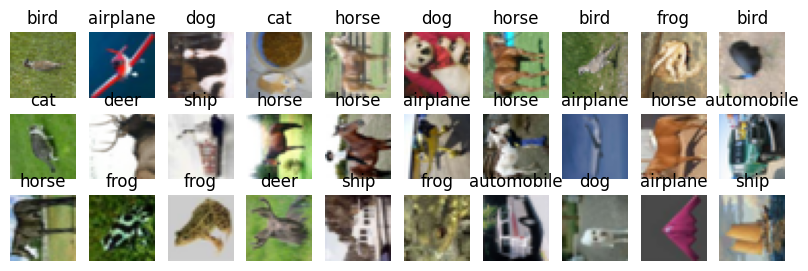

In [ ]:
fig, axs = plt.subplots(3, 10, figsize=((10, 3)))
for ax, train_file in zip(axs.ravel(), np.random.choice(len(training_data), axs.size)):
    image = training_data[train_file][0]
    image_squeezed=image.squeeze()
    ax.imshow(image_squeezed.permute(2,1,0))
    ax.set_axis_off()
    ax.set_title(names[training_data[train_file][1]])
plt.show()

In [ ]:
train_loader = DataLoader(training_data, batch_size=50000, shuffle=True)
img, lbl=next(iter(train_loader))


In [ ]:
!pip install deeplay
import deeplay as dl
from torch.nn import BCELoss, MSELoss

In [ ]:
from typing import Optional, Sequence, Callable, List

from deeplay.components import ConvolutionalEncoder2d, ConvolutionalDecoder2d
from deeplay.applications import Application
from deeplay.external import External, Optimizer, Adam, RMSprop


import torch
import torch.nn as nn

In [ ]:
class VariationalAutoEncoder(Application):
    input_size: tuple
    channels: list
    latent_dim: int
    encoder: torch.nn.Module
    decoder: torch.nn.Module
    beta: float
    reconstruction_loss: torch.nn.Module
    metrics: list
    optimizer: Optimizer

    def __init__(
        self,
        input_size: Optional[Sequence[int]] = (28, 28),
        channels: Optional[List[int]] = [32, 64],
        encoder: Optional[nn.Module] = None,
        decoder: Optional[nn.Module] = None,
        reconstruction_loss: Optional[Callable] = nn.BCELoss(reduction="sum"),
        latent_dim=int,
        beta=1,
        optimizer=None,
        **kwargs,
    ):
        red_size = [int(dim / (2 ** len(channels))) for dim in input_size]
        self.encoder = encoder or self._get_default_encoder(channels)
        self.fc_mu = nn.Linear(
            channels[-1] * red_size[0] * red_size[1],
            latent_dim,
        )
        self.fc_var = nn.Linear(
            channels[-1] * red_size[0] * red_size[1],
            latent_dim,
        )
        self.fc_dec = nn.Linear(
            latent_dim,
            channels[-1] * red_size[0] * red_size[1],
        )
        self.decoder = decoder or self._get_default_decoder(channels[::-1], red_size)
        self.reconstruction_loss = reconstruction_loss or nn.BCELoss(reduction="sum")
        self.latent_dim = latent_dim
        self.beta = beta

        super().__init__(**kwargs)

        self.optimizer = optimizer or Adam(lr=3e-4)

        @self.optimizer.params
        def params(self):
            return self.parameters()

    def _get_default_encoder(self, channels):
        encoder = ConvolutionalEncoder2d(
            3,
            channels,
            channels[-1],
        )
        encoder.postprocess.configure(nn.Flatten)

        return encoder

    def _get_default_decoder(self, channels, red_size):
        decoder = ConvolutionalDecoder2d(
            channels[0],
            channels,
            3,
            out_activation=nn.Sigmoid,
        )
        # for block in decoder.blocks[:-1]:
        #     block.upsample.configure(nn.ConvTranspose2d, kernel_size=3, stride=2, in_channels=block.in_channels, out_channels=block.out_channels)

        decoder.preprocess.configure(
            nn.Unflatten,
            dim=1,
            unflattened_size=(channels[0], red_size[0], red_size[1]))
        decoder.upsampled

        return decoder

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)

        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu

    def decode(self, z):
        x = self.fc_dec(z)
        x = self.decoder(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = self.train_preprocess(batch)
        y_hat, mu, log_var = self(x)
        rec_loss, KLD = self.compute_loss(y_hat, y, mu, log_var)
        tot_loss = rec_loss + self.beta * KLD
        loss = {"rec_loss": rec_loss, "KL": KLD, "total_loss": tot_loss}
        for name, v in loss.items():
            self.log(
                f"train_{name}",
                v,
                on_step=True,
                on_epoch=True,
                prog_bar=True,
                logger=True,
            )
        return tot_loss

    def compute_loss(self, y_hat, y, mu, log_var):
        rec_loss = self.reconstruction_loss(y_hat, y)
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return rec_loss, KLD

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        y_hat = self.decode(z)
        return y_hat, mu, log_var

In [ ]:
vae = VariationalAutoEncoder(
    input_size=(32,32),
    latent_dim=128,
    channels=[32,64],
    reconstruction_loss=nn.MSELoss(reduction="sum") ,
    beta=0.5,
).create()
print(vae)
vae_trainer = dl.Trainer(max_epochs=5, accelerator="auto")

dataset=TensorDataset(img,img)
train_loader2 = DataLoader(dataset, batch_size=2, shuffle=True)

VariationalAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): Identity()
      )
    )
    (postprocess): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=4096, out_features=128, bias=True)
  (fc_var): Linear(in_features=4096, out_features=128, bias=True)
  (fc_dec): Linear(in_features=128, out_features=4096, bias=True)
  (decoder): ConvolutionalDecoder2d(
 

In [ ]:
vae_trainer.fit(vae, train_loader2)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                ┃ Type                   ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ encoder             │ ConvolutionalEncoder2d │ 56.3 K │ train │
│ 1 │ fc_mu               │ Linear                 │  524 K │ train │
│ 2 │ fc_var              │ Linear                 │  524 K │ train │
│ 3 │ fc_dec              │ Linear                 │  528 K │ train │
│ 4 │ decoder             │ ConvolutionalDecoder2d │ 76.8 K │ train │
│ 5 │ reconstruction_loss │ MSELoss                │      0 │ train │
│ 6 │ train_metrics       │ MetricCollection       │      0 │ train │
│ 7 │ val_metrics         │ MetricCollection       │      0 │ train │
│ 8 │ test_metrics        │ MetricCollection       │      0 │ train │
│ 9 │ optimizer           │ Adam                   │      0 │ train │
└───┴─────────────────────┴────────────────────────┴────────┴───────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.7 M                                                                                                
Total estimated model params size (MB): 6

Output()

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


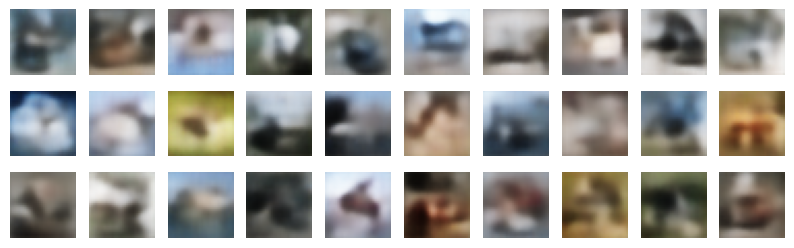

In [ ]:
images = vae.decode(torch.randn(30, vae.latent_dim)).detach().squeeze()

images = images.permute(0,2,3,1)
fig, axs = plt.subplots(3, 10, figsize=(10, 3))
for ax, image in zip(axs.ravel(), images):
    ax.imshow(image.numpy())
    ax.set_axis_off()
plt.show()

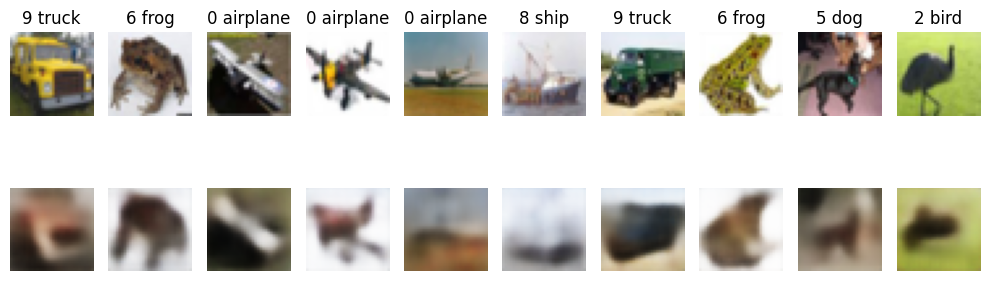

In [ ]:
test_dataloader = DataLoader(test_data, batch_size=10, shuffle=True)

fig, axs = plt.subplots(2, 10, figsize=(10, 4))


for i, (images, labels) in enumerate(test_dataloader):
    if i >= 10:
      break


    image = images[0]
    label = labels[0]


    axs[0, i].imshow(image.permute(1, 2, 0))
    axs[0, i].set_title(f"{label} {names[label]}")
    axs[0, i].axis('off')


    with torch.no_grad():
        reconstructed_image = vae(image.unsqueeze(0))[0]

    axs[1, i].imshow(reconstructed_image.squeeze().permute(1, 2, 0))

    axs[1, i].axis('off')

plt.tight_layout()
plt.show()